In [13]:
import numpy as np
import pandas as pd
import math
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    mean_squared_error, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
try:
    from xgboost import XGBClassifier
except:
    XGBClassifier = None
    warnings.warn("XGBoost not installed.")
try:
    from lightgbm import LGBMClassifier
except:
    LGBMClassifier = None
    warnings.warn("LightGBM not installed.")
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam, Adagrad
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
np.random.seed(42)
DATA_PATH = "/content/apple_share_price.xls"
TRAIN_RATIO = 0.75
CLASS_THRESHOLD = 0.0
LOOK_BACKS = [1, 3, 5, 10, 15, 20]
N_RUNS_CLASSICAL = 3
N_EPOCHS_LSTM = 15
BATCH_SIZE_LSTM = 32

In [14]:
def compute_rsi(series, window=14):
    delta = series.diff()
    gains = np.where(delta > 0, delta, 0)
    losses = np.where(delta < 0, -delta, 0)
    roll_up = pd.Series(gains).rolling(window).mean()
    roll_down = pd.Series(losses).rolling(window).mean()
    rs = roll_up / (roll_down + 1e-9)
    return 100 - (100 / (1 + rs))
def compute_technical_indicators(close):
    df = pd.DataFrame({"close": close})
    df["return"] = df["close"].pct_change()
    df["volatility_5"] = df["return"].rolling(5).std()
    df["volatility_10"] = df["return"].rolling(10).std()
    df["ma_5"] = df["close"].rolling(5).mean()
    df["ma_10"] = df["close"].rolling(10).mean()
    df["ma_20"] = df["close"].rolling(20).mean()
    df["rsi_14"] = compute_rsi(df["close"], 14)
    return df.dropna().reset_index(drop=True)
def create_direction_labels(close, threshold=0.0):
    next_return = close.pct_change().shift(-1)
    labels = (next_return > threshold).astype(int)
    return labels[:-1].reset_index(drop=True)
def evaluate_classification(y_true, y_pred, y_prob=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_prob) if y_prob is not None else np.nan
    return acc, prec, rec, f1, auc
def create_lstm_dataset(features_scaled, close_values, look_back):
    X, y = [], []
    for i in range(len(features_scaled) - look_back):
        X.append(features_scaled[i:i+look_back])
        y.append(close_values[i+look_back])
    return np.array(X), np.array(y)
def build_lstm_model(input_shape, optimizer_name="adam"):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.25))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(0.25))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(1))
    opt = Adam(learning_rate=0.001) if optimizer_name == "adam" else Adagrad(0.01)
    model.compile(loss="mean_squared_error", optimizer=opt)
    return model

In [15]:
raw = pd.read_csv(DATA_PATH, usecols=[1,2,3,4])
raw.columns = ["open", "high", "low", "close"]
raw = raw.iloc[::-1].reset_index(drop=True)
indicators = compute_technical_indicators(raw["close"])
raw_aligned = raw.iloc[len(raw)-len(indicators):].reset_index(drop=True)
features = pd.concat(
    [
        raw_aligned[["open","high","low","close"]],
        indicators[["return","volatility_5","volatility_10","ma_5","ma_10","ma_20","rsi_14"]]
    ], axis=1
)
labels = create_direction_labels(features["close"], CLASS_THRESHOLD)
features = features.iloc[:-1].reset_index(drop=True)
n = len(features)
n_train = int(TRAIN_RATIO*n)
X_train_df = features.iloc[:n_train]
X_test_df = features.iloc[n_train:]
y_train = labels.iloc[:n_train]
y_test = labels.iloc[n_train:]
scaler_classical = MinMaxScaler()
X_train_classical = scaler_classical.fit_transform(X_train_df)
X_test_classical = scaler_classical.transform(X_test_df)
scaler_lstm = MinMaxScaler()
X_all_lstm = scaler_lstm.fit_transform(features)
close_all = features["close"].values

In [16]:
from collections import defaultdict
results_classical = defaultdict(list)
def run_tuned_classical_models(X_tr, y_tr, X_te, y_te, n_runs):
    models = {
        "LogReg": LogisticRegression(
            max_iter=2000, class_weight="balanced", C=0.5
        ),
        "RandomForest": RandomForestClassifier(
            n_estimators=400, min_samples_split=4, min_samples_leaf=2,
            class_weight="balanced_subsample"
        )
    }
    if XGBClassifier:
        models["XGBoost"] = XGBClassifier(
            n_estimators=500, learning_rate=0.03,
            subsample=0.9, colsample_bytree=0.9,
            max_depth=5, eval_metric="logloss",
            reg_lambda=1.0
        )
    if LGBMClassifier:
        models["LightGBM"] = LGBMClassifier(
            n_estimators=500, learning_rate=0.03,
            subsample=0.9, colsample_bytree=0.9
        )
    for name, model in models.items():
        print(f"\n {name}")
        for run in range(1, n_runs+1):
            print(f"  Run {run}")
            if hasattr(model, "random_state"):
                model.random_state = np.random.randint(0,99999)
            model.fit(X_tr, y_tr)
            y_pred = model.predict(X_te)
            y_prob = model.predict_proba(X_te)[:,1] if hasattr(model,"predict_proba") else None
            acc, prec, rec, f1, auc = evaluate_classification(y_te, y_pred, y_prob)
            results_classical["model"].append(name)
            results_classical["run"].append(run)
            results_classical["accuracy"].append(acc)
            results_classical["precision"].append(prec)
            results_classical["recall"].append(rec)
            results_classical["f1"].append(f1)
            results_classical["roc_auc"].append(auc)
    return pd.DataFrame(results_classical)
df_classical_results = run_tuned_classical_models(
    X_train_classical, y_train,
    X_test_classical, y_test,
    N_RUNS_CLASSICAL
)
df_classical_results


=== LogReg ===
  Run 1
  Run 2
  Run 3

=== RandomForest ===
  Run 1
  Run 2
  Run 3

=== XGBoost ===
  Run 1
  Run 2
  Run 3

=== LightGBM ===
  Run 1
[LightGBM] [Info] Number of positive: 627, number of negative: 606
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 1233, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508516 -> initscore=0.034067
[LightGBM] [Info] Start training from score 0.034067


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Run 2
[LightGBM] [Info] Number of positive: 627, number of negative: 606
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 1233, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508516 -> initscore=0.034067
[LightGBM] [Info] Start training from score 0.034067


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Run 3
[LightGBM] [Info] Number of positive: 627, number of negative: 606
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 1233, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508516 -> initscore=0.034067
[LightGBM] [Info] Start training from score 0.034067


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,model,run,accuracy,precision,recall,f1,roc_auc
0,LogReg,1,0.457421,0.500000,0.067265,0.118577,0.486070
1,LogReg,2,0.457421,0.500000,0.067265,0.118577,0.486070
2,LogReg,3,0.457421,0.500000,0.067265,0.118577,0.486070
3,RandomForest,1,0.472019,0.515306,0.452915,0.482100,0.474311
4,RandomForest,2,0.481752,0.526882,0.439462,0.479218,0.477030
5,RandomForest,3,0.479319,0.524324,0.434978,0.475490,0.472021
6,XGBoost,1,0.459854,0.502646,0.426009,0.461165,0.464173
7,XGBoost,2,0.467153,0.510417,0.439462,0.472289,0.467727
8,XGBoost,3,0.481752,0.527174,0.434978,0.476658,0.470757
9,LightGBM,1,0.467153,0.510638,0.430493,0.467153,0.458806


In [17]:
mean_scores = df_classical_results.groupby("model")["f1"].mean()
best_model_name = mean_scores.idxmax()
print("Best classical model:", best_model_name)
if best_model_name == "LogReg":
    best_model = LogisticRegression(max_iter=2000, class_weight="balanced", C=0.5)
elif best_model_name == "RandomForest":
    best_model = RandomForestClassifier(
        n_estimators=400, min_samples_split=4, min_samples_leaf=2,
        class_weight="balanced_subsample"
    )
elif best_model_name == "XGBoost" and XGBClassifier:
    best_model = XGBClassifier(
        n_estimators=500, learning_rate=0.03, max_depth=5,
        subsample=0.9, colsample_bytree=0.9, eval_metric="logloss"
    )
elif best_model_name == "LightGBM" and LGBMClassifier:
    best_model = LGBMClassifier(n_estimators=500, learning_rate=0.03)
else:
    best_model = LogisticRegression(max_iter=2000)
best_model.fit(X_train_classical, y_train)
y_pred_best = best_model.predict(X_test_classical)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))
cm = confusion_matrix(y_test, y_pred_best)
print("Confusion Matrix:\n", cm)

Best classical model: RandomForest

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.49      0.46       188
           1       0.52      0.46      0.49       223

    accuracy                           0.47       411
   macro avg       0.48      0.48      0.47       411
weighted avg       0.48      0.47      0.48       411

Confusion Matrix:
 [[ 92  96]
 [120 103]]


In [18]:
results_lstm = []
for lb in LOOK_BACKS:
    print(f"\n>>> LSTM Look-back = {lb}")
    X_seq, y_seq = create_lstm_dataset(X_all_lstm, close_all, lb)
    n_seq = len(X_seq)
    n_train_seq = int(n_seq*TRAIN_RATIO)
    X_tr = X_seq[:n_train_seq]
    y_tr = y_seq[:n_train_seq]
    X_te = X_seq[n_train_seq:]
    y_te = y_seq[n_train_seq:]
    for opt in ["adam","adagrad"]:
        print(f"  Optimizer: {opt}")
        model = build_lstm_model((lb, X_tr.shape[2]), opt)
        early = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5)
        model.fit(
            X_tr, y_tr,
            epochs=N_EPOCHS_LSTM*2,
            batch_size=BATCH_SIZE_LSTM,
            verbose=0,
            validation_data=(X_te, y_te),
            callbacks=[early, reduce_lr]
        )
        pred_train = model.predict(X_tr)
        pred_test = model.predict(X_te)
        rmse_train = math.sqrt(mean_squared_error(y_tr, pred_train))
        rmse_test  = math.sqrt(mean_squared_error(y_te, pred_test))
        d_true = (np.diff(y_te) > 0).astype(int)
        d_pred = (np.diff(pred_test.squeeze()) > 0).astype(int)
        usable = min(len(d_true), len(d_pred))
        dir_acc = accuracy_score(d_true[:usable], d_pred[:usable]) if usable else np.nan
        results_lstm.append({
            "look_back": lb,
            "optimizer": opt,
            "rmse_train": rmse_train,
            "rmse_test": rmse_test,
            "direction_accuracy": dir_acc
        })
df_lstm_results = pd.DataFrame(results_lstm)
df_lstm_results


>>> LSTM Look-back = 1
  Optimizer: adam


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
  Optimizer: adagrad


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

>>> LSTM Look-back = 3
  Optimizer: adam


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
  Optimizer: adagrad


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

>>> LSTM Look-back = 5
  Optimizer: adam


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
  Optimizer: adagrad


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

>>> LSTM Look-back = 10
  Optimizer: adam


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
  Optimizer: adagrad


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

>>> LSTM Look-back = 15
  Optimizer: adam


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Optimizer: adagrad


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

>>> LSTM Look-back = 20
  Optimizer: adam


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
  Optimizer: adagrad


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


,look_back,optimizer,rmse_train,rmse_test,direction_accuracy
0,1,adam,3.073691,11.413903,0.507317
1,1,adagrad,5.585773,16.126436,0.500000
2,3,adam,2.683468,11.512541,0.497561
3,3,adagrad,3.421085,14.442513,0.500000
4,5,adam,2.712352,12.117289,0.535452
5,5,adagrad,3.839957,15.875178,0.547677
6,10,adam,24.419318,41.041389,0.480392
7,10,adagrad,4.771668,17.398138,0.546569
8,15,adam,24.370699,40.551994,0.486486
9,15,adagrad,6.121955,17.712696,0.550369


=== Classical Models Summary ===
              accuracy           precision              recall            \
                  mean       std      mean       std      mean       std   
model                                                                      
LightGBM      0.461476  0.005065  0.504457  0.005525  0.427504  0.013700   
LogReg        0.457421  0.000000  0.500000  0.000000  0.067265  0.000000   
RandomForest  0.477697  0.005065  0.522171  0.006081  0.442451  0.009335   
XGBoost       0.469586  0.011150  0.513412  0.012536  0.433483  0.006850   

                    f1             roc_auc            
                  mean       std      mean       std  
model                                                 
LightGBM      0.462712  0.008242  0.463593  0.004378  
LogReg        0.118577  0.000000  0.486070  0.000000  
RandomForest  0.478936  0.003314  0.474454  0.002508  
XGBoost       0.470038  0.007988  0.467552  0.003295  

=== LSTM Test Results ===
    look_back optimize

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


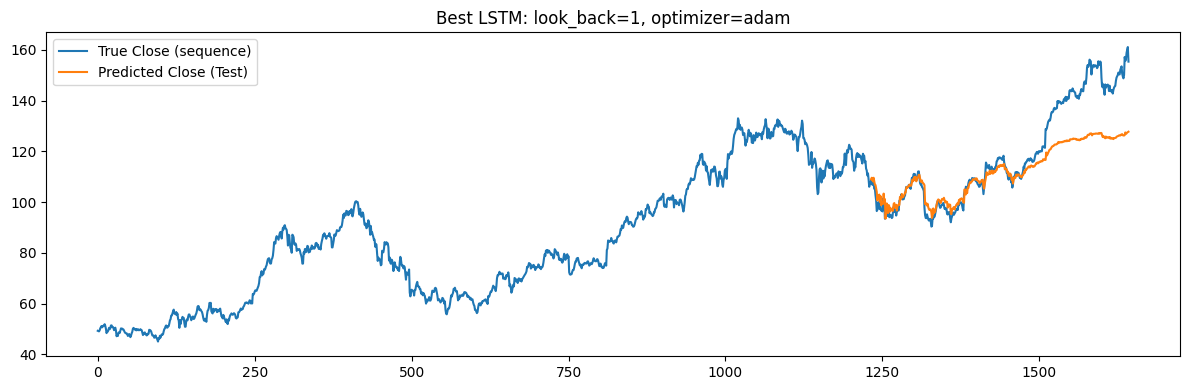

In [19]:
print("Classical Models Summary")
print(
    df_classical_results.groupby("model")
    [["accuracy","precision","recall","f1","roc_auc"]]
    .agg(["mean","std"])
)
print("\n LSTM Test Results")
print(df_lstm_results)
best_idx = df_lstm_results["rmse_test"].idxmin()
best_cfg = df_lstm_results.loc[best_idx]
print("\nBest LSTM configuration:", best_cfg.to_dict())
best_lb  = int(best_cfg["look_back"])
best_opt = best_cfg["optimizer"]
X_seq_best, y_seq_best = create_lstm_dataset(X_all_lstm, close_all, best_lb)
n_seq_best = len(X_seq_best)
n_train_best = int(n_seq_best*TRAIN_RATIO)
X_tr_best = X_seq_best[:n_train_best]
y_tr_best = y_seq_best[:n_train_best]
X_te_best = X_seq_best[n_train_best:]
y_te_best = y_seq_best[n_train_best:]
final_model = build_lstm_model((best_lb, X_tr_best.shape[2]), best_opt)
final_model.fit(
    X_tr_best, y_tr_best,
    epochs=N_EPOCHS_LSTM*2,
    batch_size=BATCH_SIZE_LSTM,
    verbose=0,
    validation_data=(X_te_best, y_te_best),
    callbacks=[EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)]
)
final_pred = final_model.predict(X_te_best).squeeze()
plt.figure(figsize=(12,4))
plt.plot(y_seq_best, label="True Close (sequence)")
pred_full = np.full_like(y_seq_best, np.nan)
pred_full[n_train_best:] = final_pred
plt.plot(pred_full, label="Predicted Close (Test)")
plt.title(f"Best LSTM: look_back={best_lb}, optimizer={best_opt}")
plt.legend()
plt.tight_layout()
plt.show()

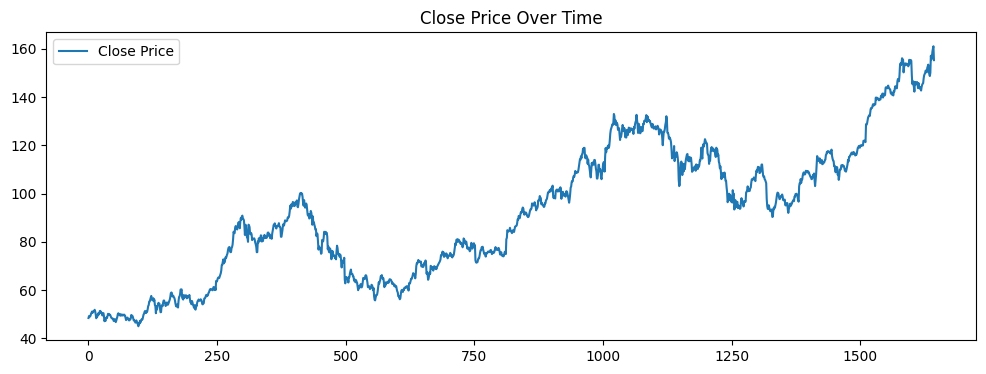

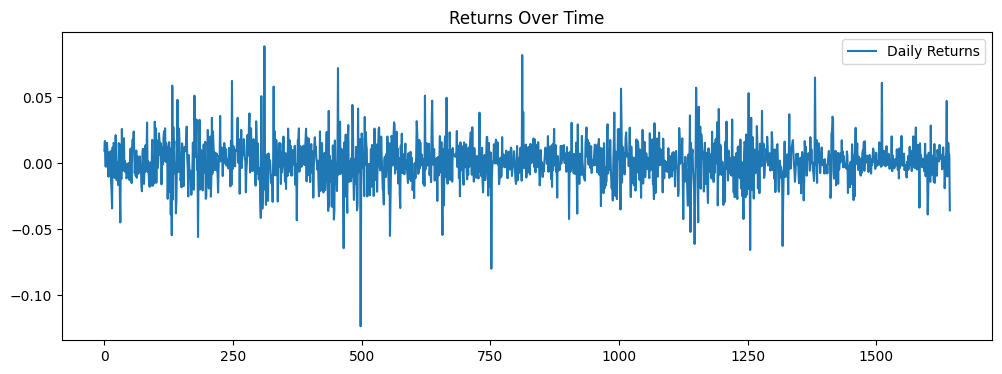

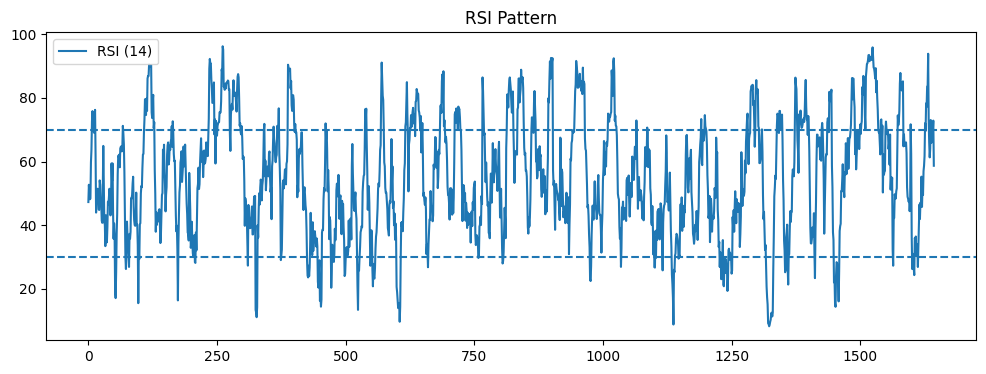

In [20]:
plt.figure(figsize=(12,4))
plt.plot(features["close"], label="Close Price")
plt.title("Close Price Over Time")
plt.legend()
plt.show()
plt.figure(figsize=(12,4))
plt.plot(features["return"], label="Daily Returns")
plt.title("Returns Over Time")
plt.legend()
plt.show()
plt.figure(figsize=(12,4))
plt.plot(features["rsi_14"], label="RSI (14)")
plt.axhline(70, linestyle="--")
plt.axhline(30, linestyle="--")
plt.title("RSI Pattern")
plt.legend()
plt.show()

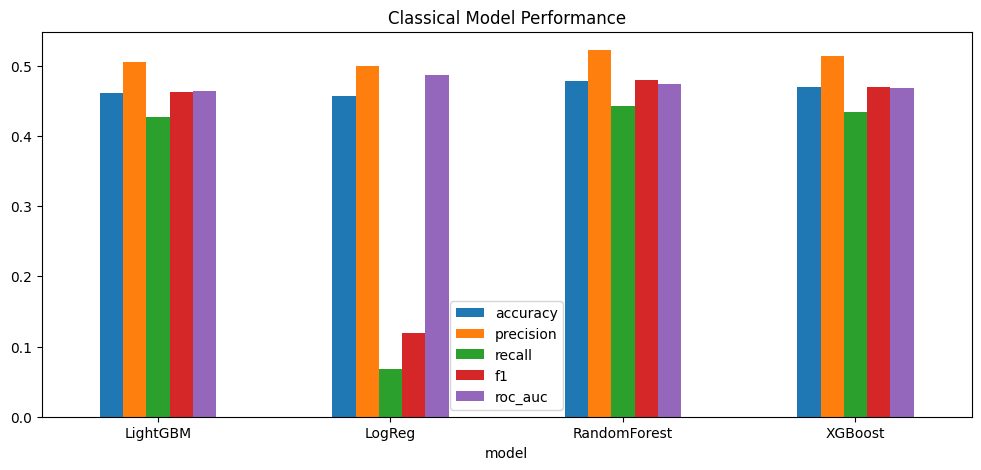

In [21]:
summary = df_classical_results.groupby("model")[["accuracy","precision","recall","f1","roc_auc"]].mean()
summary.plot(kind="bar", figsize=(12,5), title="Classical Model Performance")
plt.xticks(rotation=0)
plt.show()

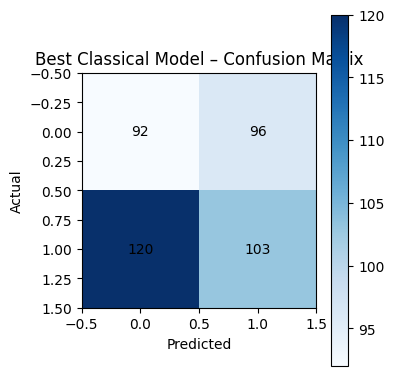

In [22]:
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(4,4))
plt.imshow(cm, cmap="Blues")
plt.title("Best Classical Model – Confusion Matrix")
plt.colorbar()
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

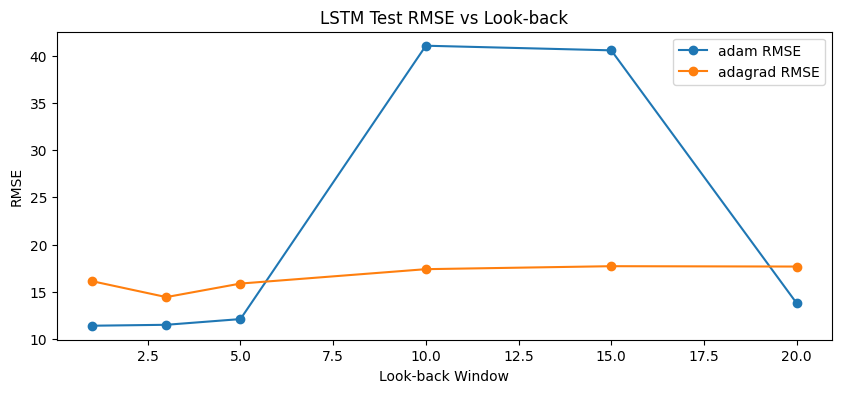

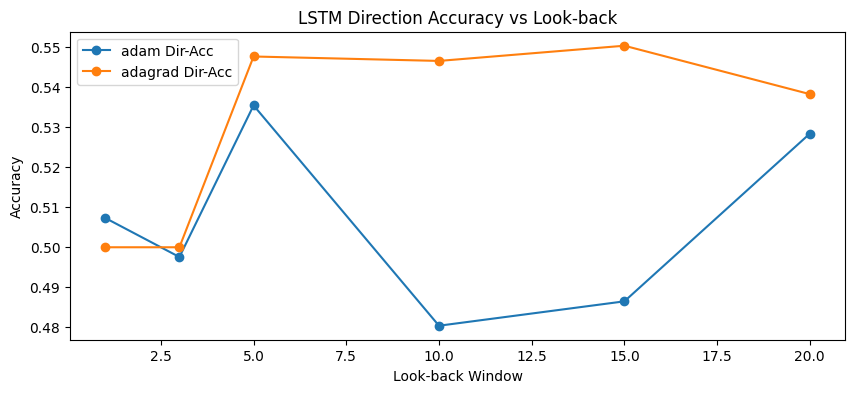

In [23]:
plt.figure(figsize=(10,4))
for opt in df_lstm_results["optimizer"].unique():
    subset = df_lstm_results[df_lstm_results["optimizer"]==opt]
    plt.plot(subset["look_back"], subset["rmse_test"], marker="o", label=f"{opt} RMSE")
plt.title("LSTM Test RMSE vs Look-back")
plt.xlabel("Look-back Window")
plt.ylabel("RMSE")
plt.legend()
plt.show()
plt.figure(figsize=(10,4))
for opt in df_lstm_results["optimizer"].unique():
    subset = df_lstm_results[df_lstm_results["optimizer"]==opt]
    plt.plot(subset["look_back"], subset["direction_accuracy"], marker="o", label=f"{opt} Dir-Acc")
plt.title("LSTM Direction Accuracy vs Look-back")
plt.xlabel("Look-back Window")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

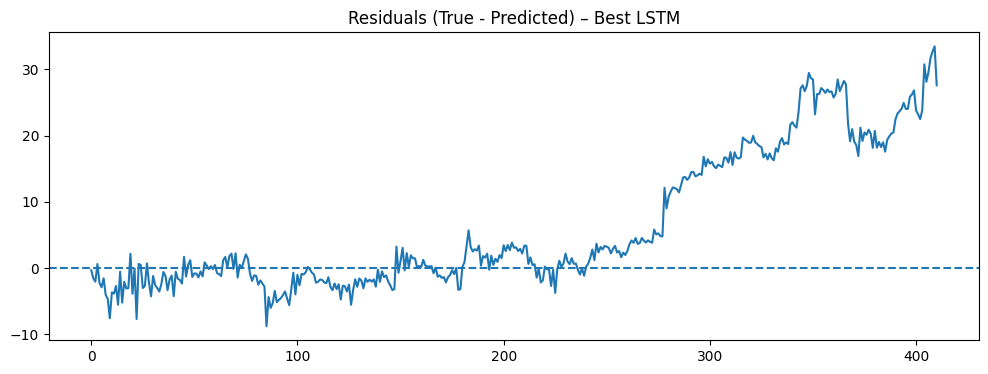

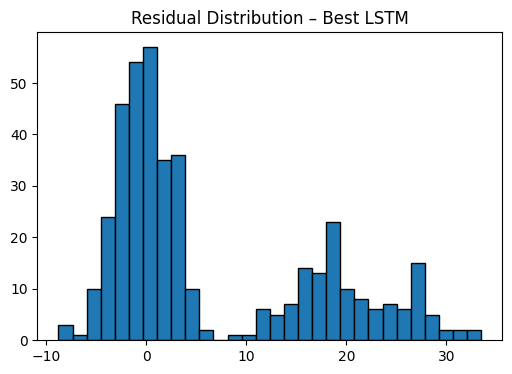

In [24]:
residuals = y_te_best - final_pred
plt.figure(figsize=(12,4))
plt.plot(residuals)
plt.axhline(0, linestyle="--")
plt.title("Residuals (True - Predicted) – Best LSTM")
plt.show()
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30, edgecolor="black")
plt.title("Residual Distribution – Best LSTM")
plt.show()